In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

2024-05-20 20:17:55.355218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 20:17:55.752937: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 20:17:57.314770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-20 20:17:57.315009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.2
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [4]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q9UQC2|GAB2_HUMAN%598%614,SGTNSPAPKKSTGSVDYLALDFQPSSPSPHRKP,1
1,sp|P18031|PTN1_HUMAN%137%153,DTNLKLTLISEDIKSYYTVRQLELENLTTQETR,1
2,sp|P08581|MET_HUMAN%1340%1356,IFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSE,1
3,sp|P35968|VGFR2_HUMAN%980%996,EKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQV,1
4,sp|P35568|IRS1_HUMAN%880%896,QQQPLLHPPEPKSPGEYVNIEFGSDQSGYLSGP,1


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(160, 2)

Validation Set:
(41, 2)


In [6]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 2
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [7]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [8]:
def PT5_classification_model(num_labels, dropout):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [10]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, 'finetuned_model.pth'))
            print(f"Saved improved model to {self.output_dir}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [12]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    # args = TrainingArguments(
    #     "./",
    #     evaluation_strategy = "epoch",
    #     logging_strategy = "epoch",
    #     save_strategy = "epoch",
    #     learning_rate=lr,
    #     per_device_train_batch_size=batch,
    #     per_device_eval_batch_size=val_batch,
    #     gradient_accumulation_steps=accum,
    #     num_train_epochs=epochs,
    #     seed = seed,
    #     deepspeed=None, #ds_config if deepspeed else None,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",  # specify the metric to determine the best model
    # )
    total_steps = epochs * len(train_df) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        metric_for_best_model='eval_loss',    # use accuracy to find the best model
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(early_stopping_patience=3, min_delta=0.001, output_dir='./model_output')],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    valid_sequences = list(valid_df['sequence'])
    valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # Apply UMAP for dimensionality reduction
    umap_embeddings = apply_umap(valid_embeddings)

    # Plot UMAP embeddings
    labels = list(valid_df['label'])
    plot_umap(umap_embeddings, labels)

    return tokenizer, model, trainer.state.log_history


In [12]:
%rm Y_dephos.sqlite3

[I 2024-05-15 23:29:08,647] A new study created in RDB with name: Y_dephos
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.714200,0.678653,0.682927
2,0.721900,0.676738,0.682927
3,0.700900,0.673793,0.682927
4,0.713500,0.670841,0.634146
5,0.700100,0.667263,0.634146
6,0.697700,0.661284,0.682927
7,0.671000,0.656515,0.682927
8,0.653300,0.651695,0.731707
9,0.671700,0.644967,0.780488
10,0.680700,0.635483,0.780488


Saved improved model to ./model_output


Removed shared tensor {'encoder.embed_tokens.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Loaded best model from ./model_output/finetuned_model.pth


{'eval_loss': 0.6354833245277405, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 5.1742, 'eval_samples_per_second': 7.924, 'eval_steps_per_second': 1.16, 'epoch': 10.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


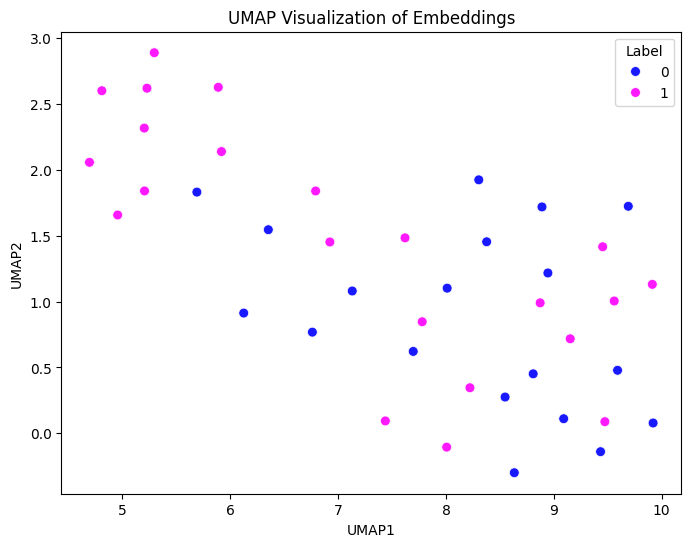

[I 2024-05-15 23:59:54,530] Trial 0 finished with values: [0.6354833245277405, 0.7804878048780488] and parameters: {'lr': 0.00011058231722699195, 'batch': 1, 'accum': 8, 'dropout_rate': 0.7666761129724191, 'weight_decay': 0.0002354692781896927, 'warmup_pct': 0.2700675001933709}. 


History:  [{'loss': 0.7142, 'learning_rate': 5.119551723471849e-06, 'epoch': 1.0, 'step': 20}, {'eval_loss': 0.6786525845527649, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 1.826, 'eval_samples_per_second': 22.453, 'eval_steps_per_second': 3.286, 'epoch': 1.0, 'step': 20}, {'loss': 0.7219, 'learning_rate': 1.0239103446943699e-05, 'epoch': 2.0, 'step': 40}, {'eval_loss': 0.676737904548645, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 4.0213, 'eval_samples_per_second': 10.196, 'eval_steps_per_second': 1.492, 'epoch': 2.0, 'step': 40}, {'loss': 0.7009, 'learning_rate': 1.535865517041555e-05, 'epoch': 3.0, 'step': 60}, {'eval_loss': 0.6737927198410034, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 6.9439, 'eval_samples_per_second': 5.904, 'eval_steps_per_second': 0.864, 'epoch': 3.0, 'step': 60}, {'loss': 0.7135, 'learning_rate': 2.0478206893887398e-05, 'epoch': 4.0, 'step': 80}, {'eval_loss': 0.6708405613899231, 'eval_accuracy': 0.6341463414634146, 'eval_runtime': 

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.693900,0.663615,0.585366
2,0.643400,0.623436,0.780488
3,0.589000,0.576932,0.756098
4,0.530500,0.538753,0.682927
5,0.419700,0.513712,0.731707
6,0.392300,0.539723,0.707317
7,0.334600,0.567228,0.756098
8,0.354100,0.607680,0.707317


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.51371169090271, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 1.8147, 'eval_samples_per_second': 22.594, 'eval_steps_per_second': 3.306, 'epoch': 8.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


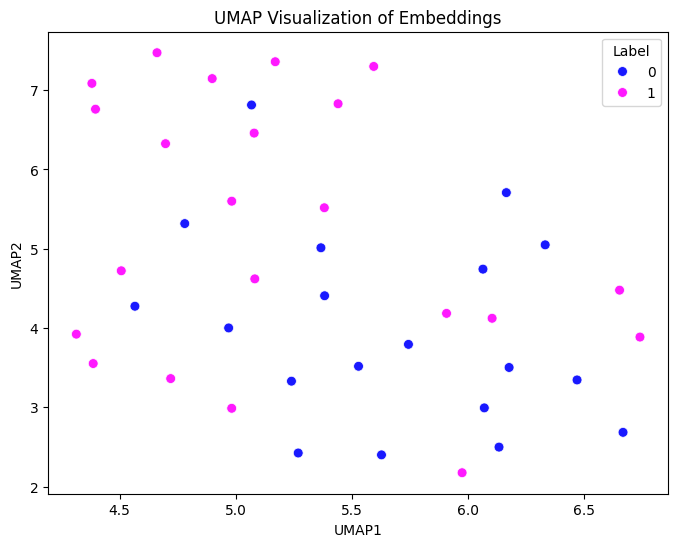

[I 2024-05-16 00:15:02,253] Trial 1 finished with values: [0.51371169090271, 0.7317073170731707] and parameters: {'lr': 0.0018193194307591226, 'batch': 2, 'accum': 8, 'dropout_rate': 0.6756701963482429, 'weight_decay': 0.0005415087410139336, 'warmup_pct': 0.12441671274485655}. 


History:  [{'loss': 0.6939, 'learning_rate': 0.00018376963947061843, 'epoch': 1.0, 'step': 10}, {'eval_loss': 0.6636154651641846, 'eval_accuracy': 0.5853658536585366, 'eval_runtime': 6.887, 'eval_samples_per_second': 5.953, 'eval_steps_per_second': 0.871, 'epoch': 1.0, 'step': 10}, {'loss': 0.6434, 'learning_rate': 0.00036753927894123687, 'epoch': 2.0, 'step': 20}, {'eval_loss': 0.6234356164932251, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 6.7415, 'eval_samples_per_second': 6.082, 'eval_steps_per_second': 0.89, 'epoch': 2.0, 'step': 20}, {'loss': 0.589, 'learning_rate': 0.0005513089184118554, 'epoch': 3.0, 'step': 30}, {'eval_loss': 0.5769320130348206, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 5.0387, 'eval_samples_per_second': 8.137, 'eval_steps_per_second': 1.191, 'epoch': 3.0, 'step': 30}, {'loss': 0.5305, 'learning_rate': 0.0007350785578824737, 'epoch': 4.0, 'step': 40}, {'eval_loss': 0.5387529730796814, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 5.8

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.775900,0.672054,0.658537
2,0.788000,0.651242,0.658537
3,0.705400,0.638199,0.682927
4,0.697100,0.628229,0.585366
5,0.662100,0.618123,0.658537
6,0.751300,0.609649,0.707317
7,0.627200,0.603024,0.707317
8,0.637600,0.597376,0.682927
9,0.648600,0.595515,0.682927
10,0.646300,0.594918,0.682927


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Loaded best model from ./model_output/finetuned_model.pth


{'eval_loss': 0.5955148339271545, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 1.9213, 'eval_samples_per_second': 21.34, 'eval_steps_per_second': 3.123, 'epoch': 10.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


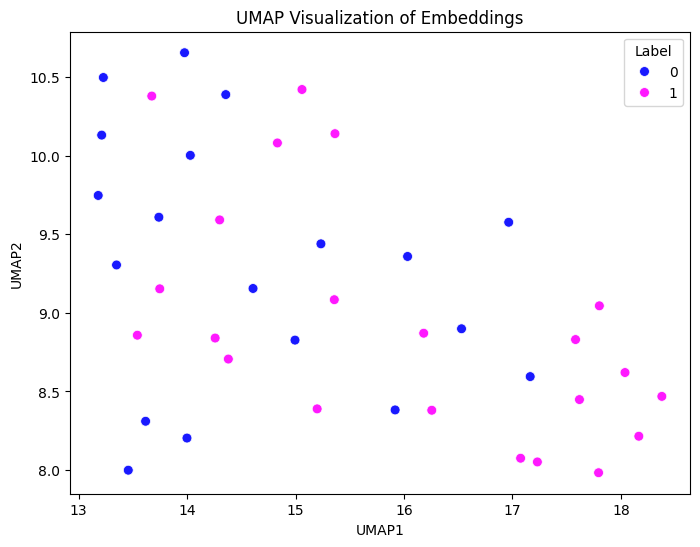

History:  [{'loss': 0.7759, 'learning_rate': 0.00024314891443210878, 'epoch': 1.0, 'step': 40}, {'eval_loss': 0.6720536947250366, 'eval_accuracy': 0.6585365853658537, 'eval_runtime': 6.5836, 'eval_samples_per_second': 6.228, 'eval_steps_per_second': 0.911, 'epoch': 1.0, 'step': 40}, {'loss': 0.788, 'learning_rate': 0.00021613236838409668, 'epoch': 2.0, 'step': 80}, {'eval_loss': 0.6512420773506165, 'eval_accuracy': 0.6585365853658537, 'eval_runtime': 6.9244, 'eval_samples_per_second': 5.921, 'eval_steps_per_second': 0.866, 'epoch': 2.0, 'step': 80}, {'loss': 0.7054, 'learning_rate': 0.00018911582233608462, 'epoch': 3.0, 'step': 120}, {'eval_loss': 0.6381993889808655, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 6.9618, 'eval_samples_per_second': 5.889, 'eval_steps_per_second': 0.862, 'epoch': 3.0, 'step': 120}, {'loss': 0.6971, 'learning_rate': 0.00016209927628807252, 'epoch': 4.0, 'step': 160}, {'eval_loss': 0.6282294392585754, 'eval_accuracy': 0.5853658536585366, 'eval_runtim

[I 2024-05-16 00:33:55,371] Trial 2 finished with values: [0.5955148339271545, 0.6829268292682927] and parameters: {'lr': 0.0002444997417345094, 'batch': 2, 'accum': 2, 'dropout_rate': 0.8896441520140961, 'weight_decay': 1.9256572659743762e-05, 'warmup_pct': 0.04855582062193914}. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.699600,0.674735,0.634146
2,0.675900,0.658453,0.707317
3,0.649900,0.633475,0.731707
4,0.602300,0.603354,0.707317
5,0.541300,0.572654,0.682927
6,0.505000,0.544585,0.731707
7,0.442200,0.532325,0.682927
8,0.381800,0.525056,0.731707
9,0.350600,0.519312,0.756098
10,0.289500,0.520680,0.756098


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Loaded best model from ./model_output/finetuned_model.pth


{'eval_loss': 0.5193122029304504, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 1.8272, 'eval_samples_per_second': 22.439, 'eval_steps_per_second': 3.284, 'epoch': 10.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


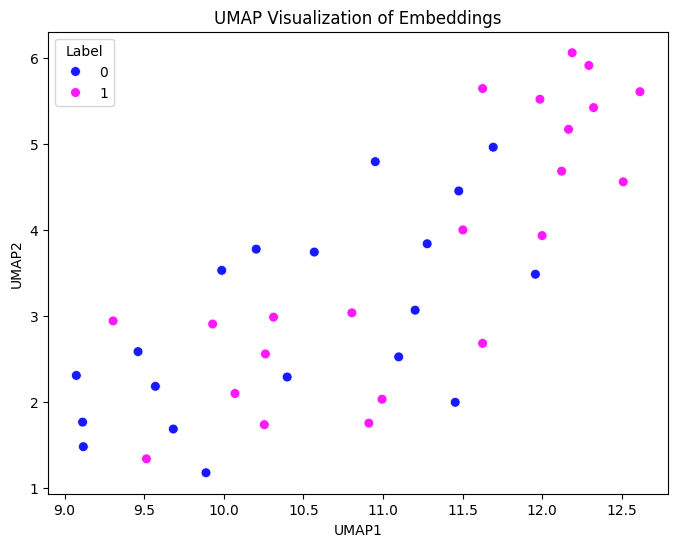

[I 2024-05-16 00:48:51,907] Trial 3 finished with values: [0.5193122029304504, 0.7560975609756098] and parameters: {'lr': 0.0012567035595427748, 'batch': 4, 'accum': 8, 'dropout_rate': 0.3667307864770569, 'weight_decay': 0.00013194757024765502, 'warmup_pct': 0.2863591655616572}. 


History:  [{'loss': 0.6996, 'learning_rate': 5.511857717292872e-05, 'epoch': 1.0, 'step': 5}, {'eval_loss': 0.6747348308563232, 'eval_accuracy': 0.6341463414634146, 'eval_runtime': 2.6228, 'eval_samples_per_second': 15.632, 'eval_steps_per_second': 2.288, 'epoch': 1.0, 'step': 5}, {'loss': 0.6759, 'learning_rate': 0.00011023715434585743, 'epoch': 2.0, 'step': 10}, {'eval_loss': 0.6584533452987671, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 5.1525, 'eval_samples_per_second': 7.957, 'eval_steps_per_second': 1.164, 'epoch': 2.0, 'step': 10}, {'loss': 0.6499, 'learning_rate': 0.00016535573151878614, 'epoch': 3.0, 'step': 15}, {'eval_loss': 0.6334750652313232, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 4.0166, 'eval_samples_per_second': 10.208, 'eval_steps_per_second': 1.494, 'epoch': 3.0, 'step': 15}, {'loss': 0.6023, 'learning_rate': 0.00022047430869171487, 'epoch': 4.0, 'step': 20}, {'eval_loss': 0.6033544540405273, 'eval_accuracy': 0.7073170731707317, 'eval_runtime':

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683800,0.619712,0.707317
2,0.641400,0.576015,0.634146
3,0.685500,0.567434,0.756098
4,0.611700,0.778197,0.634146
5,0.680200,0.927348,0.707317
6,0.585800,1.744062,0.658537


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5674338936805725, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 1.8995, 'eval_samples_per_second': 21.584, 'eval_steps_per_second': 3.159, 'epoch': 6.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


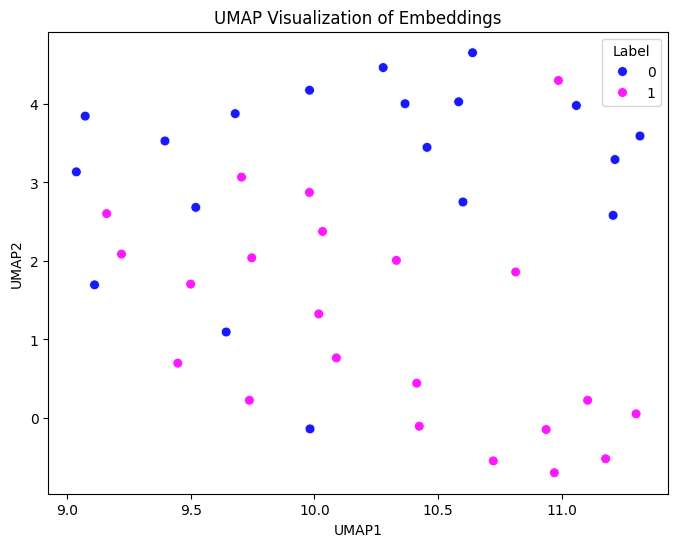

History:  [{'loss': 0.6838, 'learning_rate': 0.001168028807004327, 'epoch': 1.0, 'step': 20}, {'eval_loss': 0.6197122931480408, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 1.8213, 'eval_samples_per_second': 22.511, 'eval_steps_per_second': 3.294, 'epoch': 1.0, 'step': 20}, {'loss': 0.6414, 'learning_rate': 0.002336057614008654, 'epoch': 2.0, 'step': 40}, {'eval_loss': 0.5760149955749512, 'eval_accuracy': 0.6341463414634146, 'eval_runtime': 2.3513, 'eval_samples_per_second': 17.437, 'eval_steps_per_second': 2.552, 'epoch': 2.0, 'step': 40}, {'loss': 0.6855, 'learning_rate': 0.0035040864210129814, 'epoch': 3.0, 'step': 60}, {'eval_loss': 0.5674338936805725, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 2.9204, 'eval_samples_per_second': 14.039, 'eval_steps_per_second': 2.054, 'epoch': 3.0, 'step': 60}, {'loss': 0.6117, 'learning_rate': 0.004672115228017308, 'epoch': 4.0, 'step': 80}, {'eval_loss': 0.7781972885131836, 'eval_accuracy': 0.6341463414634146, 'eval_runtime': 6.

[I 2024-05-16 00:57:04,792] Trial 4 finished with values: [0.5674338936805725, 0.7560975609756098] and parameters: {'lr': 0.004672115228017308, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8171911170504492, 'weight_decay': 1.85934778252727e-05, 'warmup_pct': 0.20138353779423512}. 


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.678500,0.605548,0.804878
2,0.531600,0.531581,0.707317
3,0.451300,0.630641,0.707317
4,0.348900,0.772277,0.756098
5,0.276700,1.265728,0.707317


Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5315811634063721, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 6.9808, 'eval_samples_per_second': 5.873, 'eval_steps_per_second': 0.86, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


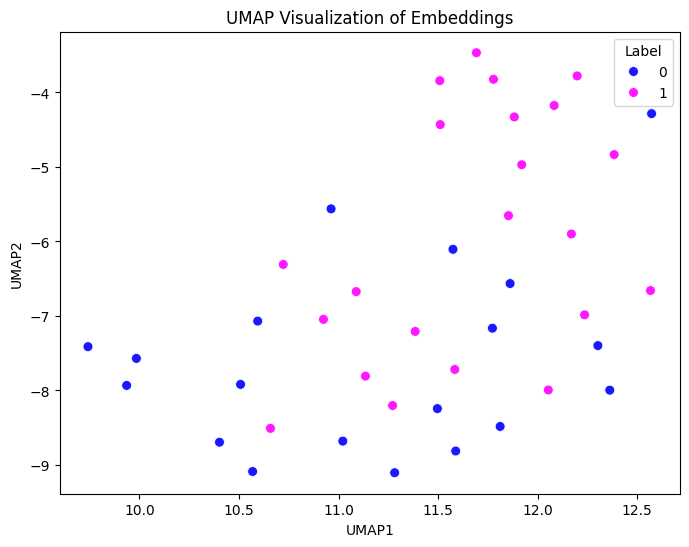

History:  [{'loss': 0.6785, 'learning_rate': 0.00037302838826364787, 'epoch': 1.0, 'step': 40}, {'eval_loss': 0.6055484414100647, 'eval_accuracy': 0.8048780487804879, 'eval_runtime': 6.9722, 'eval_samples_per_second': 5.88, 'eval_steps_per_second': 0.861, 'epoch': 1.0, 'step': 40}, {'loss': 0.5316, 'learning_rate': 0.0007460567765272957, 'epoch': 2.0, 'step': 80}, {'eval_loss': 0.5315811634063721, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 6.8598, 'eval_samples_per_second': 5.977, 'eval_steps_per_second': 0.875, 'epoch': 2.0, 'step': 80}, {'loss': 0.4513, 'learning_rate': 0.0011190851647909436, 'epoch': 3.0, 'step': 120}, {'eval_loss': 0.6306410431861877, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 6.9823, 'eval_samples_per_second': 5.872, 'eval_steps_per_second': 0.859, 'epoch': 3.0, 'step': 120}, {'loss': 0.3489, 'learning_rate': 0.0014921135530545915, 'epoch': 4.0, 'step': 160}, {'eval_loss': 0.7722765207290649, 'eval_accuracy': 0.7560975609756098, 'eval_runtime':

[I 2024-05-16 01:07:56,310] Trial 5 finished with values: [0.5315811634063721, 0.7073170731707317] and parameters: {'lr': 0.001659976327773233, 'batch': 2, 'accum': 2, 'dropout_rate': 0.604125241215519, 'weight_decay': 7.493224381291337e-05, 'warmup_pct': 0.22323694666052363}. 


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.769600,0.678767,0.682927
2,0.770100,0.676902,0.682927
3,0.782100,0.675335,0.682927
4,0.749000,0.674076,0.658537
5,0.791300,0.672442,0.609756
6,0.693700,0.670977,0.585366
7,0.762000,0.670031,0.585366
8,0.767700,0.669465,0.585366
9,0.750200,0.669049,0.609756
10,0.793100,0.668911,0.609756


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6694649457931519, 'eval_accuracy': 0.5853658536585366, 'eval_runtime': 1.785, 'eval_samples_per_second': 22.969, 'eval_steps_per_second': 3.361, 'epoch': 10.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


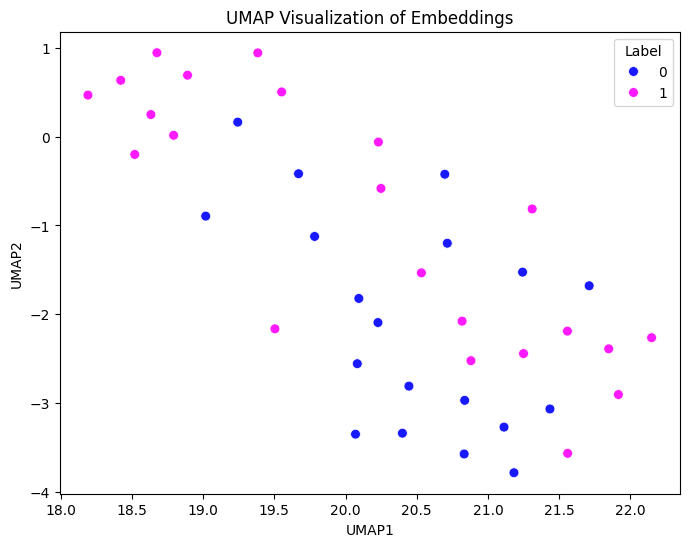

[I 2024-05-16 01:22:20,765] Trial 6 finished with values: [0.6694649457931519, 0.5853658536585366] and parameters: {'lr': 2.246864152799188e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8843809010266548, 'weight_decay': 1.8045727637869314e-05, 'warmup_pct': 0.0843788559844972}. 


History:  [{'loss': 0.7696, 'learning_rate': 1.3617358501813261e-05, 'epoch': 1.0, 'step': 20}, {'eval_loss': 0.6787671446800232, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 6.9437, 'eval_samples_per_second': 5.905, 'eval_steps_per_second': 0.864, 'epoch': 1.0, 'step': 20}, {'loss': 0.7701, 'learning_rate': 2.152684218250719e-05, 'epoch': 2.0, 'step': 40}, {'eval_loss': 0.6769017577171326, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 1.8919, 'eval_samples_per_second': 21.671, 'eval_steps_per_second': 3.171, 'epoch': 2.0, 'step': 40}, {'loss': 0.7821, 'learning_rate': 1.883598690969379e-05, 'epoch': 3.0, 'step': 60}, {'eval_loss': 0.6753345131874084, 'eval_accuracy': 0.6829268292682927, 'eval_runtime': 1.7169, 'eval_samples_per_second': 23.88, 'eval_steps_per_second': 3.495, 'epoch': 3.0, 'step': 60}, {'loss': 0.749, 'learning_rate': 1.6145131636880394e-05, 'epoch': 4.0, 'step': 80}, {'eval_loss': 0.674075722694397, 'eval_accuracy': 0.6585365853658537, 'eval_runtime': 1

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689100,0.669574,0.634146
2,0.663800,0.639680,0.707317
3,0.623900,0.602355,0.731707
4,0.574900,0.568299,0.707317
5,0.490500,0.530683,0.804878
6,0.420700,0.508478,0.731707
7,0.381600,0.489588,0.756098
8,0.289300,0.533999,0.804878
9,0.219400,0.602970,0.780488
10,0.172300,0.596297,0.780488


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.4895881116390228, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 1.9168, 'eval_samples_per_second': 21.39, 'eval_steps_per_second': 3.13, 'epoch': 10.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


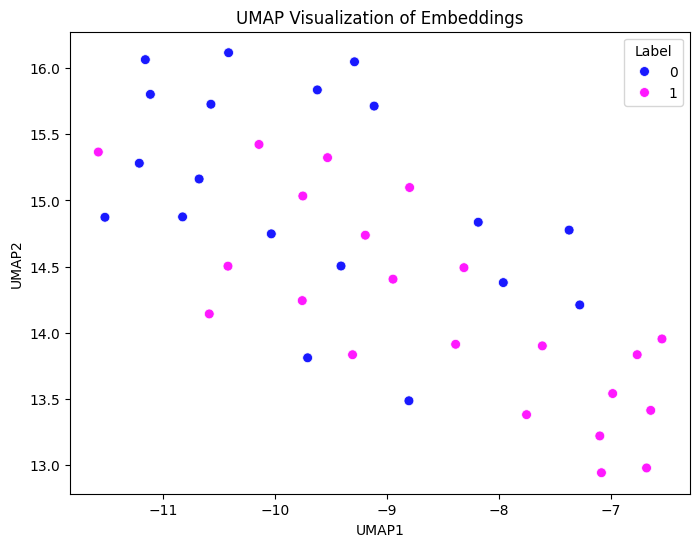

History:  [{'loss': 0.6891, 'learning_rate': 2.6714209463702214e-05, 'epoch': 1.0, 'step': 40}, {'eval_loss': 0.6695742607116699, 'eval_accuracy': 0.6341463414634146, 'eval_runtime': 1.8409, 'eval_samples_per_second': 22.272, 'eval_steps_per_second': 3.259, 'epoch': 1.0, 'step': 40}, {'loss': 0.6638, 'learning_rate': 5.342841892740443e-05, 'epoch': 2.0, 'step': 80}, {'eval_loss': 0.6396796703338623, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 1.8785, 'eval_samples_per_second': 21.826, 'eval_steps_per_second': 3.194, 'epoch': 2.0, 'step': 80}, {'loss': 0.6239, 'learning_rate': 8.014262839110664e-05, 'epoch': 3.0, 'step': 120}, {'eval_loss': 0.6023549437522888, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 1.8975, 'eval_samples_per_second': 21.607, 'eval_steps_per_second': 3.162, 'epoch': 3.0, 'step': 120}, {'loss': 0.5749, 'learning_rate': 0.00010685683785480886, 'epoch': 4.0, 'step': 160}, {'eval_loss': 0.5682985186576843, 'eval_accuracy': 0.7073170731707317, 'eval_runt

[I 2024-05-16 01:42:08,077] Trial 7 finished with values: [0.4895881116390228, 0.7560975609756098] and parameters: {'lr': 0.00020903868905346984, 'batch': 1, 'accum': 4, 'dropout_rate': 0.38832674503593423, 'weight_decay': 0.0005933215687317266, 'warmup_pct': 0.19578188258995016}. 


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684600,0.650659,0.731707
2,0.617700,0.586546,0.780488
3,0.516000,0.534028,0.658537
4,0.416200,0.476395,0.804878
5,0.305400,0.524813,0.804878
6,0.217200,0.566688,0.707317
7,0.129400,0.621553,0.707317


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.4763951301574707, 'eval_accuracy': 0.8048780487804879, 'eval_runtime': 1.7957, 'eval_samples_per_second': 22.832, 'eval_steps_per_second': 3.341, 'epoch': 7.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


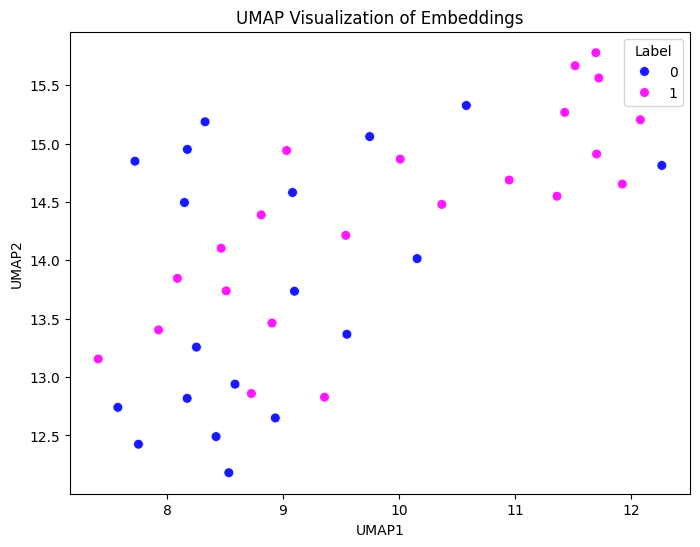

[I 2024-05-16 01:57:13,682] Trial 8 finished with values: [0.4763951301574707, 0.8048780487804879] and parameters: {'lr': 0.0005230835468331856, 'batch': 1, 'accum': 8, 'dropout_rate': 0.249393371466119, 'weight_decay': 0.00022371572349701594, 'warmup_pct': 0.0659331898500009}. 


History:  [{'loss': 0.6846, 'learning_rate': 9.963496130155916e-05, 'epoch': 1.0, 'step': 20}, {'eval_loss': 0.6506590247154236, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 5.4424, 'eval_samples_per_second': 7.533, 'eval_steps_per_second': 1.102, 'epoch': 1.0, 'step': 20}, {'loss': 0.6177, 'learning_rate': 0.00019926992260311833, 'epoch': 2.0, 'step': 40}, {'eval_loss': 0.5865455269813538, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 5.1792, 'eval_samples_per_second': 7.916, 'eval_steps_per_second': 1.158, 'epoch': 2.0, 'step': 40}, {'loss': 0.516, 'learning_rate': 0.0002989048839046775, 'epoch': 3.0, 'step': 60}, {'eval_loss': 0.534028172492981, 'eval_accuracy': 0.6585365853658537, 'eval_runtime': 4.9507, 'eval_samples_per_second': 8.282, 'eval_steps_per_second': 1.212, 'epoch': 3.0, 'step': 60}, {'loss': 0.4162, 'learning_rate': 0.00039853984520623665, 'epoch': 4.0, 'step': 80}, {'eval_loss': 0.4763951301574707, 'eval_accuracy': 0.8048780487804879, 'eval_runtime': 2.

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699800,0.657528,0.707317
2,0.646600,0.610323,0.731707
3,0.538600,0.571020,0.658537
4,0.446000,0.504600,0.731707
5,0.316300,0.562854,0.658537
6,0.396900,0.598876,0.756098
7,0.368000,0.671532,0.707317
8,0.285600,0.902916,0.658537
9,0.548200,1.020296,0.731707


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5988759994506836, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 1.7878, 'eval_samples_per_second': 22.933, 'eval_steps_per_second': 3.356, 'epoch': 9.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


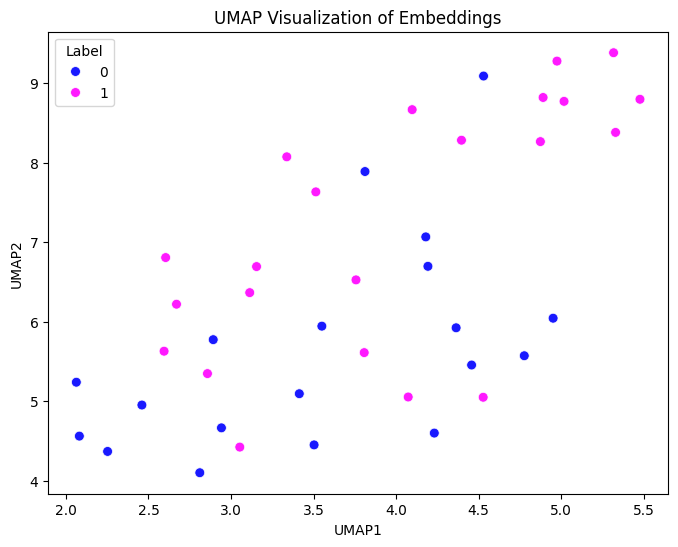

[I 2024-05-16 02:09:48,460] Trial 9 finished with values: [0.5988759994506836, 0.7560975609756098] and parameters: {'lr': 0.0040769606648794095, 'batch': 4, 'accum': 4, 'dropout_rate': 0.7180895011249031, 'weight_decay': 0.0007876119678321857, 'warmup_pct': 0.26905599143582104}. 


History:  [{'loss': 0.6998, 'learning_rate': 0.0003810243612036831, 'epoch': 1.0, 'step': 10}, {'eval_loss': 0.6575279235839844, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 1.7584, 'eval_samples_per_second': 23.316, 'eval_steps_per_second': 3.412, 'epoch': 1.0, 'step': 10}, {'loss': 0.6466, 'learning_rate': 0.0007620487224073662, 'epoch': 2.0, 'step': 20}, {'eval_loss': 0.6103232502937317, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 1.8157, 'eval_samples_per_second': 22.581, 'eval_steps_per_second': 3.305, 'epoch': 2.0, 'step': 20}, {'loss': 0.5386, 'learning_rate': 0.0011430730836110494, 'epoch': 3.0, 'step': 30}, {'eval_loss': 0.57101970911026, 'eval_accuracy': 0.6585365853658537, 'eval_runtime': 1.8086, 'eval_samples_per_second': 22.67, 'eval_steps_per_second': 3.318, 'epoch': 3.0, 'step': 30}, {'loss': 0.446, 'learning_rate': 0.0015240974448147324, 'epoch': 4.0, 'step': 40}, {'eval_loss': 0.5045999884605408, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 1.8

In [13]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_df=my_train, 
        valid_df=my_valid, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
    )
    print("History: ", history)
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///Y_dephos.sqlite3",  # Specify the storage URL here.
                            study_name="Y_dephos")
study.optimize(objective, n_trials=10)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


{'lr': 0.0005230835468331856, 'batch': 1, 'accum': 8, 'dropout_rate': 0.249393371466119, 'weight_decay': 0.00022371572349701594, 'warmup_pct': 0.0659331898500009}. 

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 2576387.0



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.688700,0.664146,0.609756
2,0.651000,0.623391,0.804878
3,0.589700,0.577956,0.731707
4,0.517600,0.534253,0.731707
5,0.421800,0.512990,0.780488
6,0.338400,0.510645,0.707317
7,0.266500,0.540723,0.682927
8,0.188400,0.589105,0.731707
9,0.119500,0.797069,0.731707


Saved improved model to ./model_output


Removed shared tensor {'encoder.embed_tokens.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Saved improved model to ./model_output
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5106452107429504, 'eval_accuracy': 0.7073170731707317, 'eval_runtime': 1.8516, 'eval_samples_per_second': 22.143, 'eval_steps_per_second': 3.24, 'epoch': 9.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


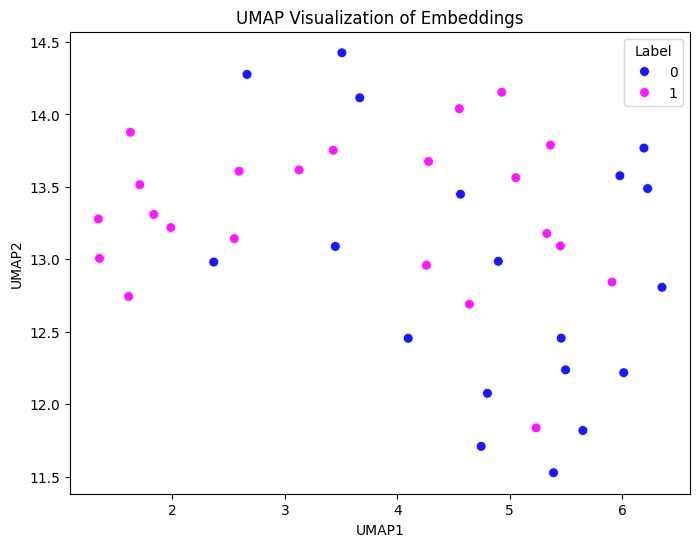

In [13]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=1, accum=8, epochs=20, seed=42, lr=0.0005230835468331856, dropout=0.249393371466119, weight_decay=0.00022371572349701594, warmup_pct=0.0659331898500009)

In [20]:
val_loss

[0.6357417702674866,
 0.5537726879119873,
 0.5104828476905823,
 0.47216400504112244,
 0.6357417702674866]

In [21]:
loss

[0.6798, 0.594, 0.4781, 0.4014]

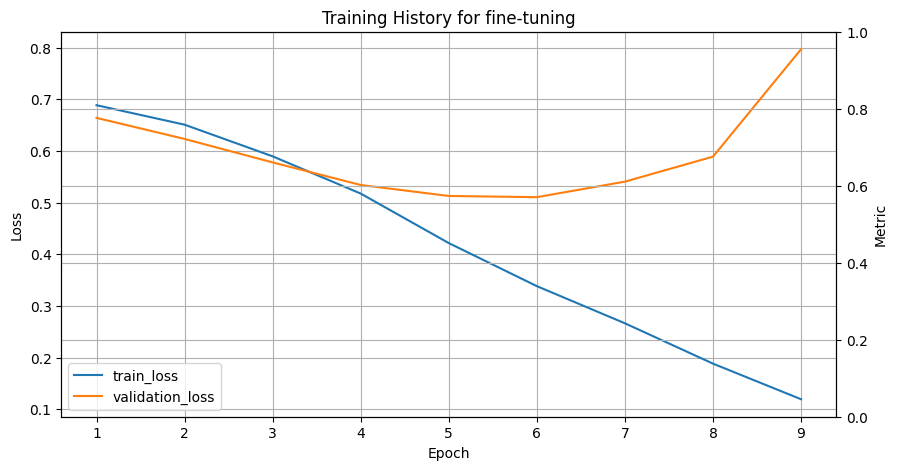

In [14]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [15]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.5)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [ ]:
# def save_model(model, filepath):
#     torch.save(model.state_dict(), filepath)

# save_model(model, "../finetuned_model.pth")

In [16]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model.pth",num_labels=2)

ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 2576387.0



In [17]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [20]:
# model = from_pretrained("model_output")

In [18]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P20963|CD3Z_HUMAN%126%142,IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM,1
1,sp|P00533|EGFR_HUMAN%1076%1092,ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP,1
2,sp|P08581|MET_HUMAN%1349%1365,YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT,1
3,sp|P09619|PGFRB_HUMAN%841%857,KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE,1
4,sp|Q13480|GAB1_HUMAN%573%589,VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG,1


In [19]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM      1
1  ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP      1
2  YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT      1
3  KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE      1
4  VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG      1


In [20]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.639359 |      0.846154 |      0.791667 |       0.82 |  0.894231 |
+----------+---------------+---------------+------------+-----------+
[[22  4]
 [ 5 19]]


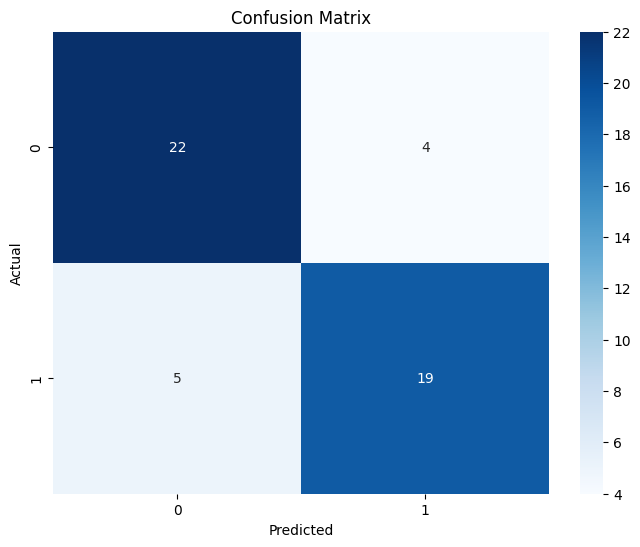

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()
